In [ ]:
#
# REP Analysis for the Flat Scan Sampling single core
# João Inácio, Mar. 31st, 2021
# 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [7]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4
S = 1/2
SZ = int(2 * S + 1)

L = 4
N_atm = 1 * L ** 2

max_E = 4 * S * S * N_atm * NN / 2
max_M = 2 * S * N_atm

NE = int(1 + (max_E / 2))
NM = N_atm + 1

energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

REP_vals = 10**np.array([3, 4, 5, 6])
skip = N_atm

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3


In [8]:
# Get the data

n_run = 1000

JDOS_all = list()
for i in range(len(REP_vals)):
    JDOS_all.append(list())

wall_time_all = np.zeros((n_run, len(REP_vals)))
q_time_E_all = np.zeros((n_run, len(REP_vals)))

cfg_chkbrd = np.zeros((n_run, len(REP_vals)))
cfg_slice = np.zeros((n_run, len(REP_vals)))
cfg_zerozero = np.zeros((n_run, len(REP_vals)))

JDOS_mean = list()
wall_time_mean = list()
q_time_E_mean = list()

k = 0
for REP in REP_vals:
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/L", str(L), "/", str(int(np.log10(REP))), 
                             "/", str(run), "_JDOS_FSS_Ising_SpinS_", dim, "_", lattice, 
                             "_SZ", str(SZ), "_L", str(L), "_REP_1E", 
                             str(int(np.log10(REP))), "_skip_", str(skip)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero[run - 1, k] = JDOS[np.where(energies == 0)[0][0], q_max+1]

        JDOS_all[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")

            q_time_E = np.zeros(q_max)
            for i in range(0, q_max):
                line = data_file.readline().strip("\n").split(" ")
                q_time_E[i] = float(line[4])

            wall_time_all[run - 1, k] = float(data_file.readline().strip("\n"))
            q_time_E_all[run - 1, k] = np.sum(q_time_E)
    
    JDOS_mean.append(sum(JDOS_all[k]) / n_run)
    wall_time_mean.append(sum(wall_time_all[:, k]) / n_run)
    q_time_E_mean.append(np.average(q_time_E_all[:, k]))
    
    print(REP)
    print("Mean Wall time: {:.5f} seconds".format(wall_time_mean[k]))
    print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean[k]))
    print("------------------------------------")
    
    k += 1


1000
Mean Wall time: 0.19818 seconds
Mean q_time / E: 0.04141 seconds
------------------------------------
10000
Mean Wall time: 1.92673 seconds
Mean q_time / E: 0.37977 seconds
------------------------------------
100000
Mean Wall time: 18.91955 seconds
Mean q_time / E: 3.66983 seconds
------------------------------------
1000000
Mean Wall time: 188.78046 seconds
Mean q_time / E: 36.53464 seconds
------------------------------------


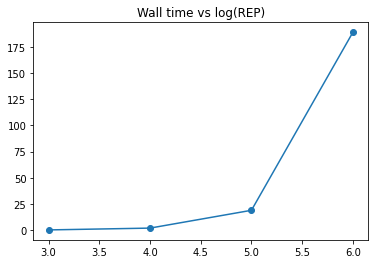

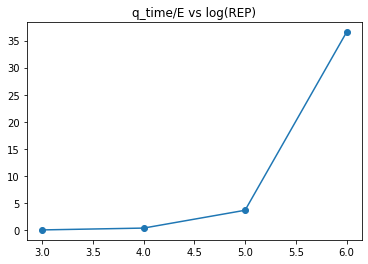

In [9]:
# Plot Wall time and q_time/E

# Wall time
plt.figure(1)
plt.plot(np.log10(REP_vals), wall_time_mean, '-o')
plt.title("Wall time vs log(REP)")
    
# q_time/E
plt.figure(2)
plt.plot(np.log10(REP_vals), q_time_E_mean, '-o')
plt.title("q_time/E vs log(REP)")

plt.show()
    

In [10]:
# Fit normal distributions to configurations

fit_chkbrd = np.zeros((len(REP_vals), 2))
fit_slice = np.zeros((len(REP_vals), 2))
fit_zerozero = np.zeros((len(REP_vals), 2))

for k in range(len(REP_vals)):
    print(REP_vals[k])
    
    # Checkerboard
    fit_chkbrd[k] = norm.fit(cfg_chkbrd[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_chkbrd[k, 0], fit_chkbrd[k, 1]))

    # Slice
    fit_slice[k] = norm.fit(cfg_slice[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_slice[k, 0], fit_slice[k, 1]))

    # Zerozero
    fit_zerozero[k] = norm.fit(cfg_zerozero[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_zerozero[k, 0], fit_zerozero[k, 1]))
    
    print("------------------------------------")


1000
mean: 1.99527; var: 0.05041
mean: 7.97254; var: 0.32910
mean: 4351.99548; var: 25.46096
------------------------------------
10000
mean: 1.99947; var: 0.01618
mean: 8.00040; var: 0.10252
mean: 4355.98938; var: 7.76227
------------------------------------
100000
mean: 2.00004; var: 0.00522
mean: 7.99970; var: 0.03236
mean: 4356.05849; var: 2.50125
------------------------------------
1000000
mean: 2.00006; var: 0.00156
mean: 8.00055; var: 0.00980
mean: 4355.99449; var: 0.78271
------------------------------------


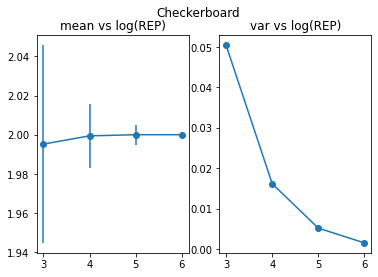

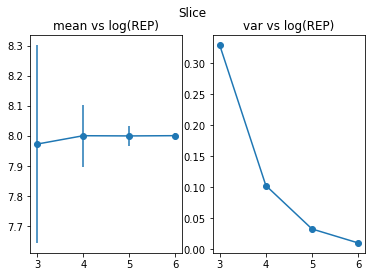

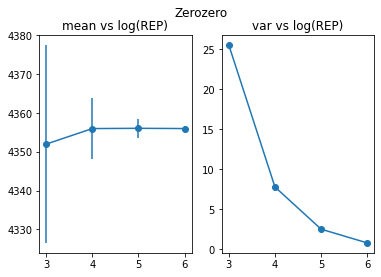

In [11]:
# Plot mean and var for the fitted distribuitions

# Checkerboard
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.suptitle("Checkerboard")

ax1.errorbar(np.log10(REP_vals), fit_chkbrd[:, 0], fit_chkbrd[:, 1], marker='o')
ax1.set_title("mean vs log(REP)")

ax2.plot(np.log10(REP_vals), fit_chkbrd[:, 1], '-o')
ax2.set_title("var vs log(REP)")

# Slice
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.suptitle("Slice")

ax1.errorbar(np.log10(REP_vals), fit_slice[:, 0], fit_slice[:, 1], marker='o')
ax1.set_title("mean vs log(REP)")

ax2.plot(np.log10(REP_vals), fit_slice[:, 1], '-o')
ax2.set_title("var vs log(REP)")
    
# Zerozero
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.suptitle("Zerozero")

ax1.errorbar(np.log10(REP_vals), fit_zerozero[:, 0], fit_zerozero[:, 1], marker='o')
ax1.set_title("mean vs log(REP)")

ax2.plot(np.log10(REP_vals), fit_zerozero[:, 1], '-o')
ax2.set_title("var vs log(REP)")

plt.show()


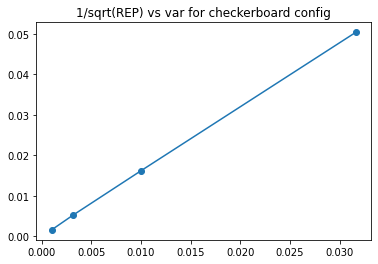

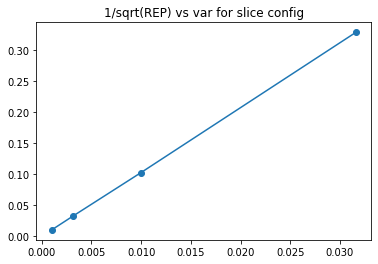

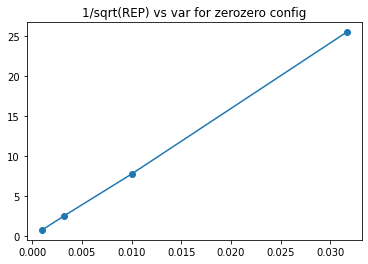

In [12]:
# 1/sqrt(REP) vs var

plt.figure(1)
plt.plot(1/np.sqrt(REP_vals), fit_chkbrd[:, 1], '-o')
plt.title("1/sqrt(REP) vs var for checkerboard config")

plt.figure(2)
plt.plot(1/np.sqrt(REP_vals), fit_slice[:, 1], '-o')
plt.title("1/sqrt(REP) vs var for slice config")

plt.figure(3)
plt.plot(1/np.sqrt(REP_vals), fit_zerozero[:, 1], '-o')
plt.title("1/sqrt(REP) vs var for zerozero config")

plt.show()

1000
Mean absolute error: 0.73159 
Mean error: -0.01321 
Var error: 0.26171 
------------------------------------
10000
Mean absolute error: 0.23026 
Mean error: 0.00064 
Var error: 0.08166 
------------------------------------
100000
Mean absolute error: 0.07338 
Mean error: -0.00019 
Var error: 0.02663 
------------------------------------
1000000
Mean absolute error: 0.02261 
Mean error: 0.00050 
Var error: 0.00794 
------------------------------------


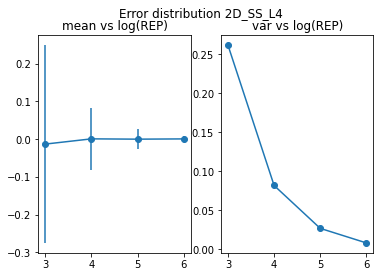

In [13]:
# If L = 4, compute error

if L == 4:
    JDOS_exact = np.loadtxt('JDOS_exact_L4_SS.txt')
    
    mean_error_abs = list()
    mean_error = list()
    var_error = list()
    
    for k in range(len(REP_vals)):
        error_all = list()
        error_all_abs = list()
        
        for run in range(n_run):
            JDOS_error = JDOS_all[k][run] - JDOS_exact
            JDOS_error = JDOS_error[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
            error_all.append(np.sum(np.sum(JDOS_error)))

            JDOS_error_abs = np.abs(JDOS_all[k][run] - JDOS_exact)
            JDOS_error_abs = JDOS_error_abs[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
            error_all_abs.append(np.sum(np.sum(JDOS_error_abs)))
        
        mean_error_abs.append(np.mean(error_all_abs))
        
        fit_error = norm.fit(error_all)
        mean_error.append(fit_error[0])
        var_error.append(fit_error[1])
        
        print(REP_vals[k])
        print("Mean absolute error: {:.5f} ".format(mean_error_abs[k]))
        print("Mean error: {:.5f} ".format(mean_error[k]))
        print("Var error: {:.5f} ".format(var_error[k]))
        print("------------------------------------")
    
    fig, [ax1, ax2] = plt.subplots(1, 2)
    fig.suptitle("Error distribution " + dim + "_" + 
              lattice + "_L" + str(L))

    ax1.errorbar(np.log10(REP_vals), mean_error, var_error, marker='o')
    ax1.set_title("mean vs log(REP)")

    ax2.plot(np.log10(REP_vals), var_error, '-o')
    ax2.set_title("var vs log(REP)")
    
    plt.show()
    